In [1]:
#Import libraries
import numpy as np
import pandas as pd
from sklearn import neighbors, datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
#!pip install seaborn
#!pip install yellowbrick
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)
import missingno as msno

# Read Data and show the basic structure

In [2]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')

In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


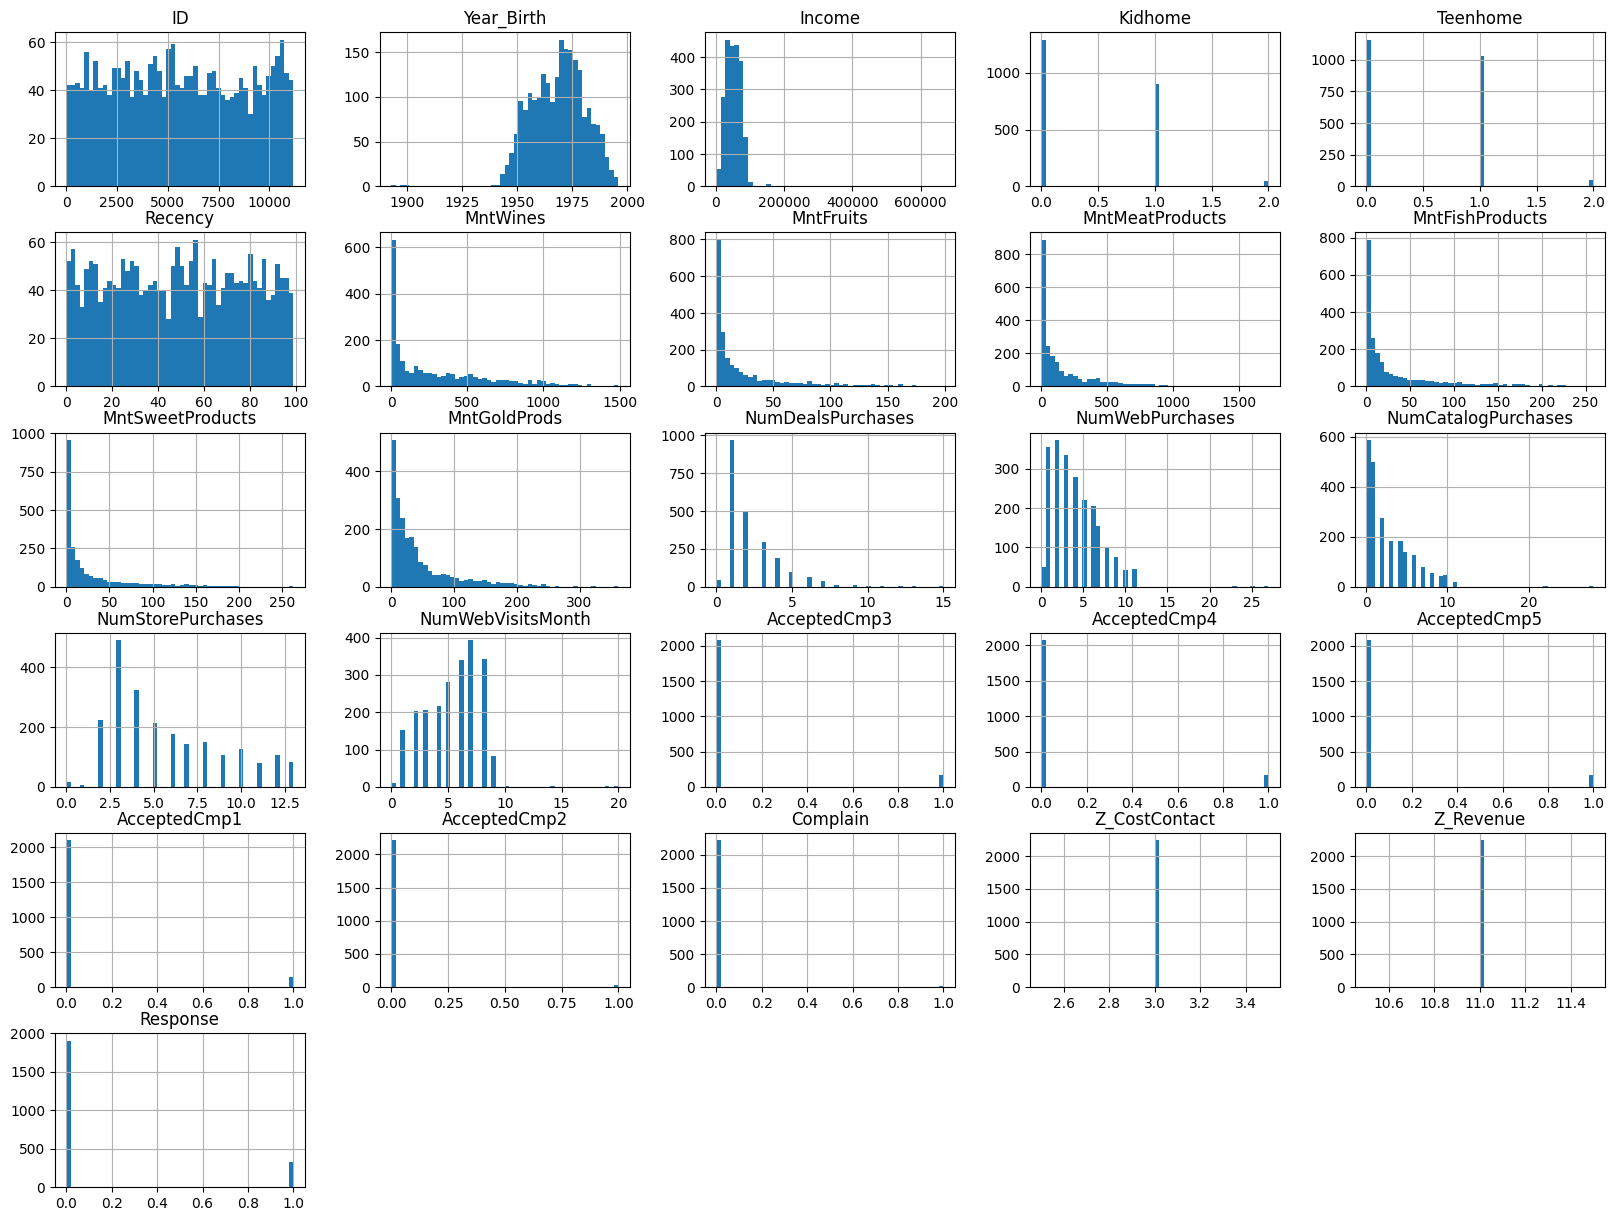

In [4]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

# HANDLING CATEGORICAL DATA

In [5]:
# Applying one-hot encoding to the 'Education' categorical variable
from sklearn.preprocessing import OneHotEncoder
education_ohe = pd.get_dummies(df['Education'], prefix='Education')

# Adding the one-hot encoded columns to the main DataFrame
df = pd.concat([df, education_ohe], axis=1)

# Displaying the first few rows to verify the new columns
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,3,11,1,False,False,True,False,False
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,3,11,0,False,False,True,False,False
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,3,11,0,False,False,True,False,False
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,3,11,0,False,False,True,False,False
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,3,11,0,False,False,False,False,True


# MAKING NEW FEATURES

In [6]:
#Zohreh
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format='mixed')
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


In [7]:
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
df["days_a_customer"] = days #attribute name changed: df["Customer_For"] = days
df["days_a_customer"] = pd.to_numeric(df["days_a_customer"], errors="coerce")

In [8]:
#2020 is the oldest dataset update date. So we consider that as the analysis date
df["Age"] = 2020-df["Year_Birth"]

In [9]:
#Arash: creating marital status dictionary and replacing values in data frame?
unique_marital_strings = list(df['Marital_Status'].unique())
df['Marital_Status'].value_counts()

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [10]:
marital_status_dict = {'Single': 1 ,'Together': 2, 'Married': 2, 'Divorced': 1, 'Widow': 1, 'Alone': 1, 'Absurd': np.NaN, 'YOLO': np.NaN}
df['adults_in_home'] = df['Marital_Status']
df['adults_in_home'] = df['adults_in_home'].map(lambda x : marital_status_dict.get(x))

In [11]:
#Zohreh
df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]
df["Children"]=df["Kidhome"]+df["Teenhome"]
df["Family_Size"] = df['adults_in_home']+ df["Children"]
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]

In [12]:
#Taufiq
df['Total_Purchases'] = df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases']].sum(axis=1)

# HANDLING MISSING DATA

In [13]:
#Zohreh
print(df.isnull().sum())

ID                       0
Year_Birth               0
Education                0
Marital_Status           0
Income                  24
Kidhome                  0
Teenhome                 0
Dt_Customer              0
Recency                  0
MntWines                 0
MntFruits                0
MntMeatProducts          0
MntFishProducts          0
MntSweetProducts         0
MntGoldProds             0
NumDealsPurchases        0
NumWebPurchases          0
NumCatalogPurchases      0
NumStorePurchases        0
NumWebVisitsMonth        0
AcceptedCmp3             0
AcceptedCmp4             0
AcceptedCmp5             0
AcceptedCmp1             0
AcceptedCmp2             0
Complain                 0
Z_CostContact            0
Z_Revenue                0
Response                 0
Education_2n Cycle       0
Education_Basic          0
Education_Graduation     0
Education_Master         0
Education_PhD            0
days_a_customer          0
Age                      0
adults_in_home           4
S

<Axes: >

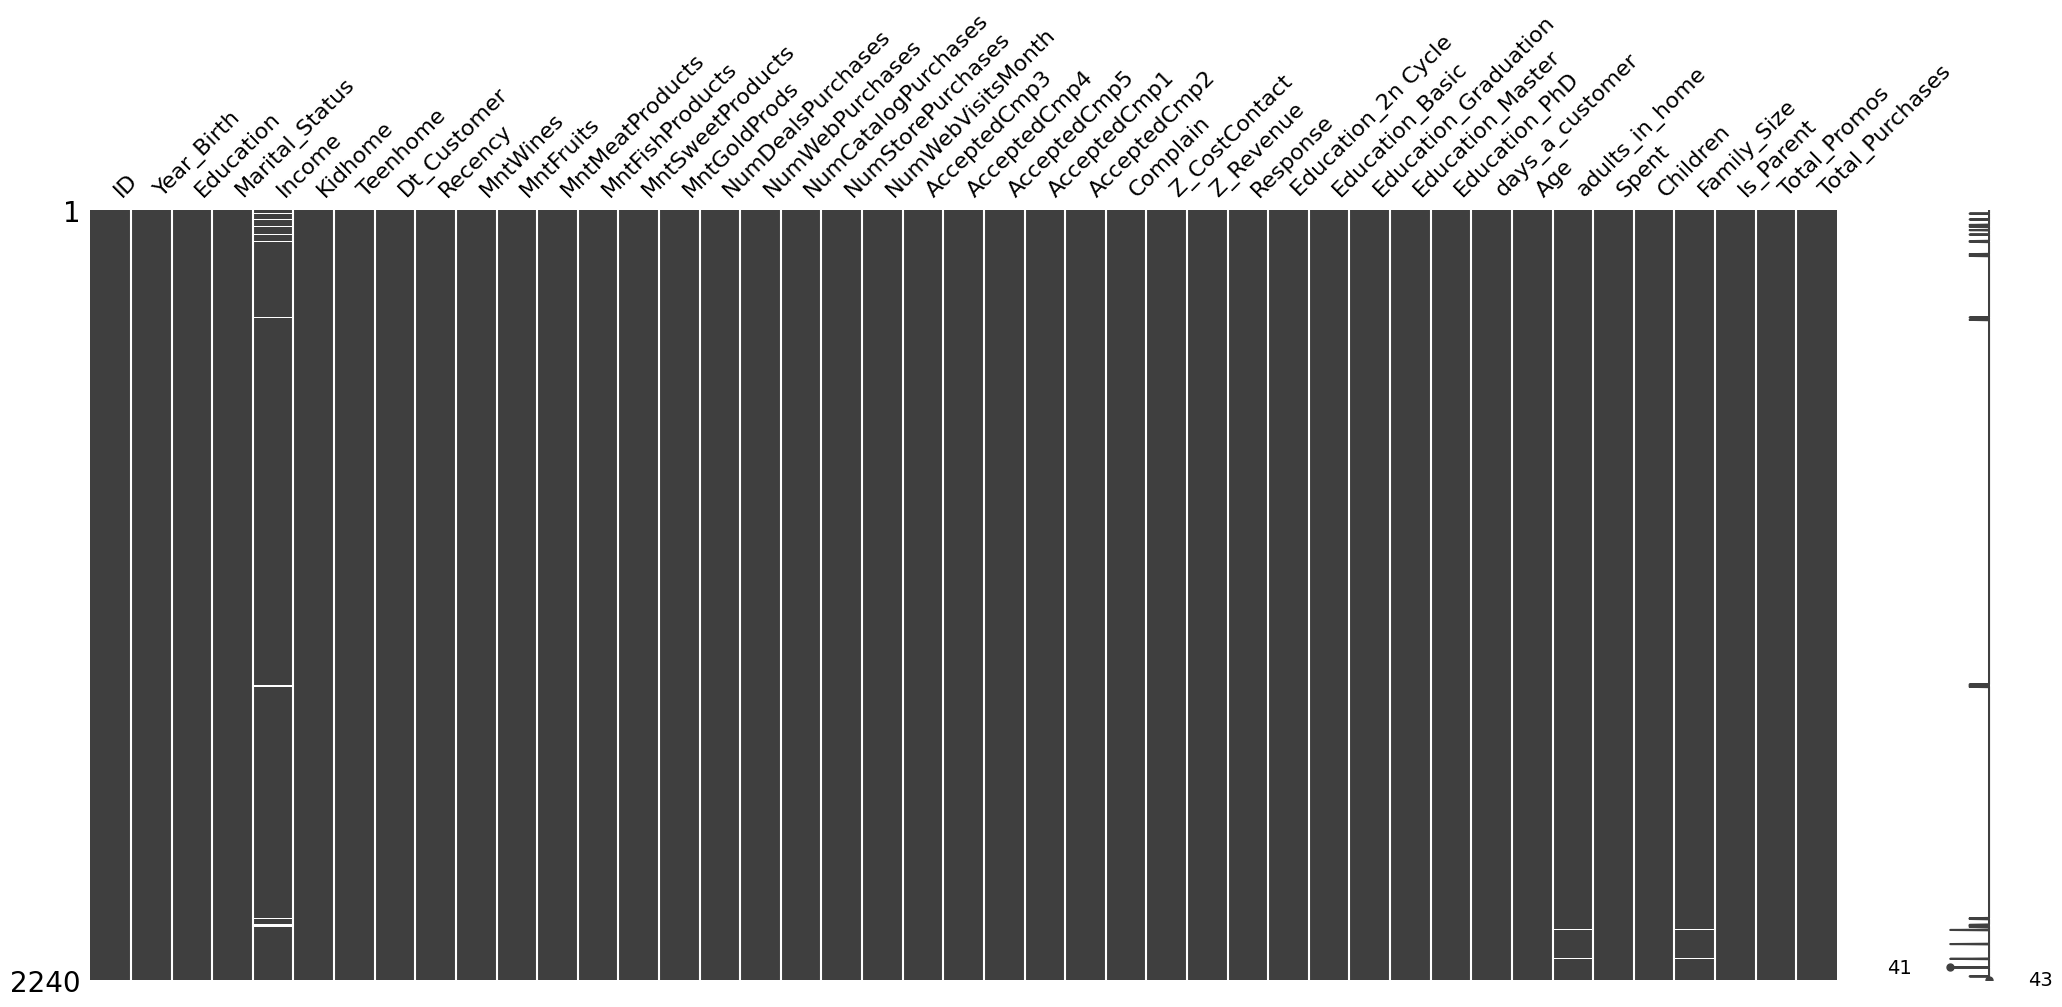

In [14]:
msno.matrix(df, )

In [15]:
data1 = df['Income']
data1.dropna(inplace=True)

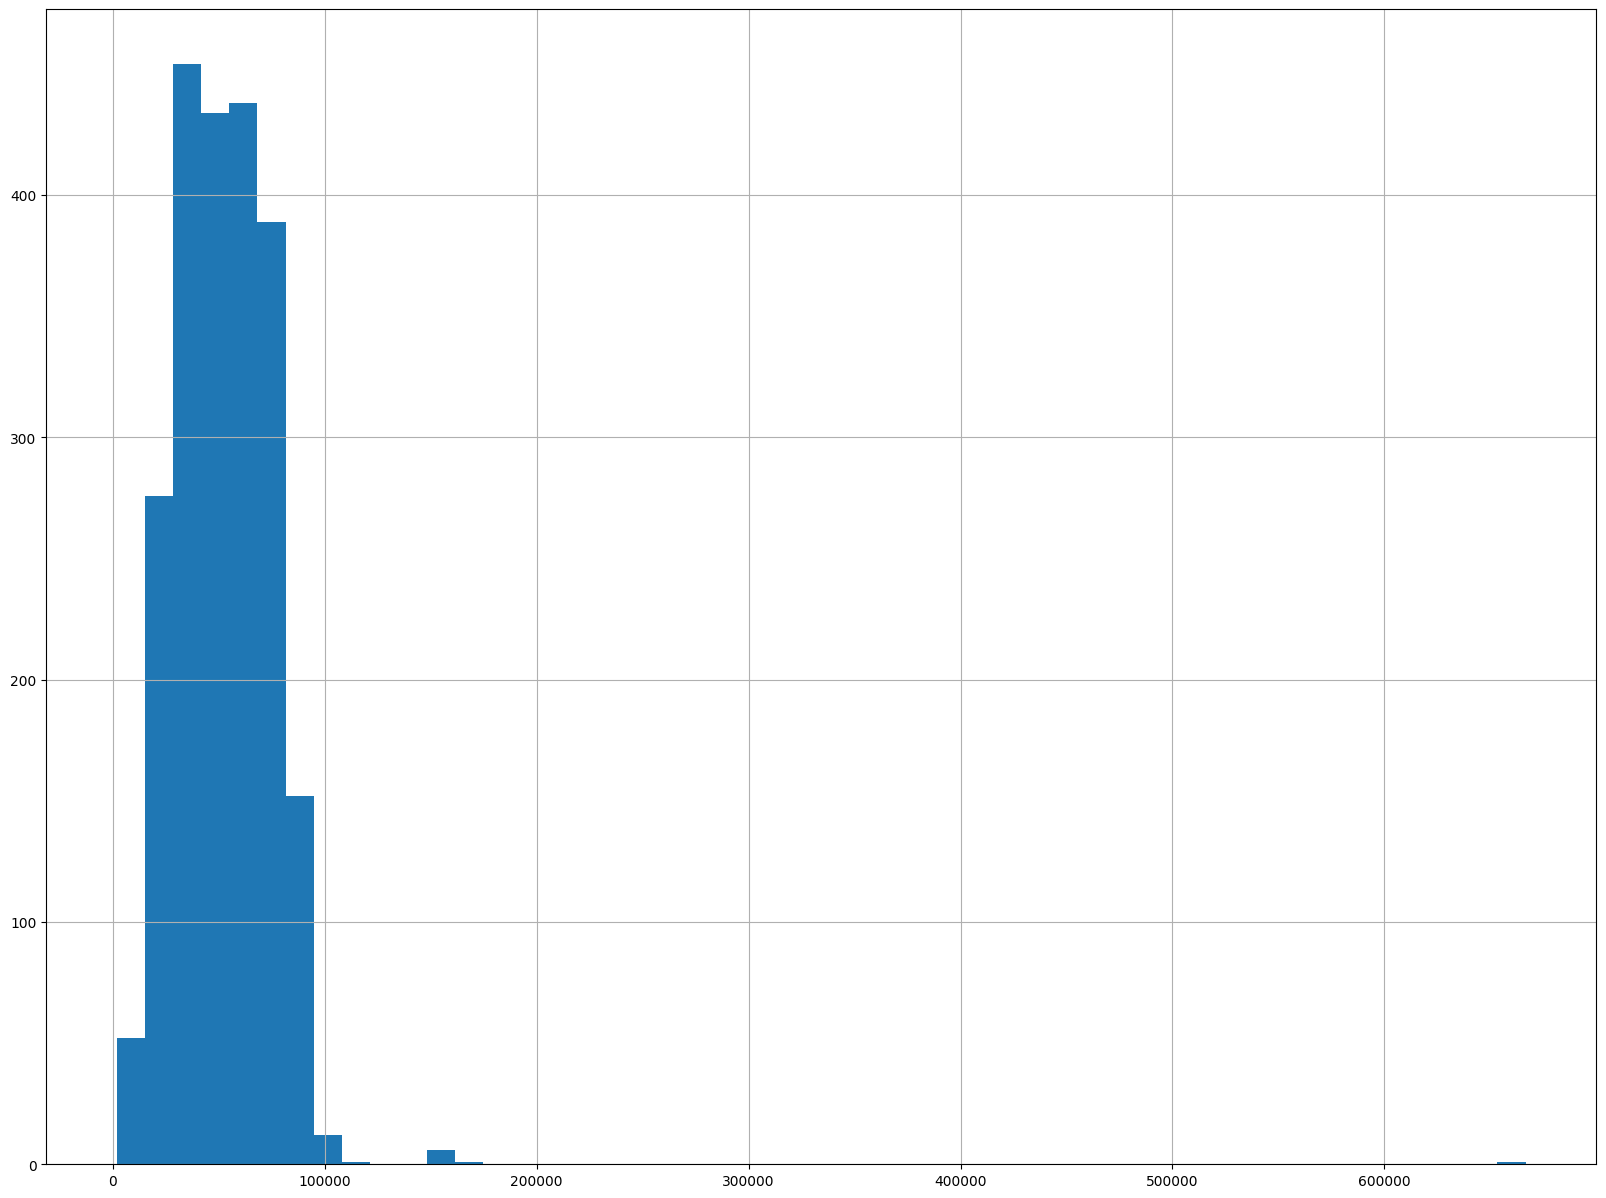

In [16]:
data1.hist(bins=50, figsize=(20,15))
plt.show()

In [17]:
print(data1.mean())
print(data1.median())

52247.25135379061
51381.5


In [18]:
data2 = df['Income']

data2.fillna(data2.median(), inplace=True)

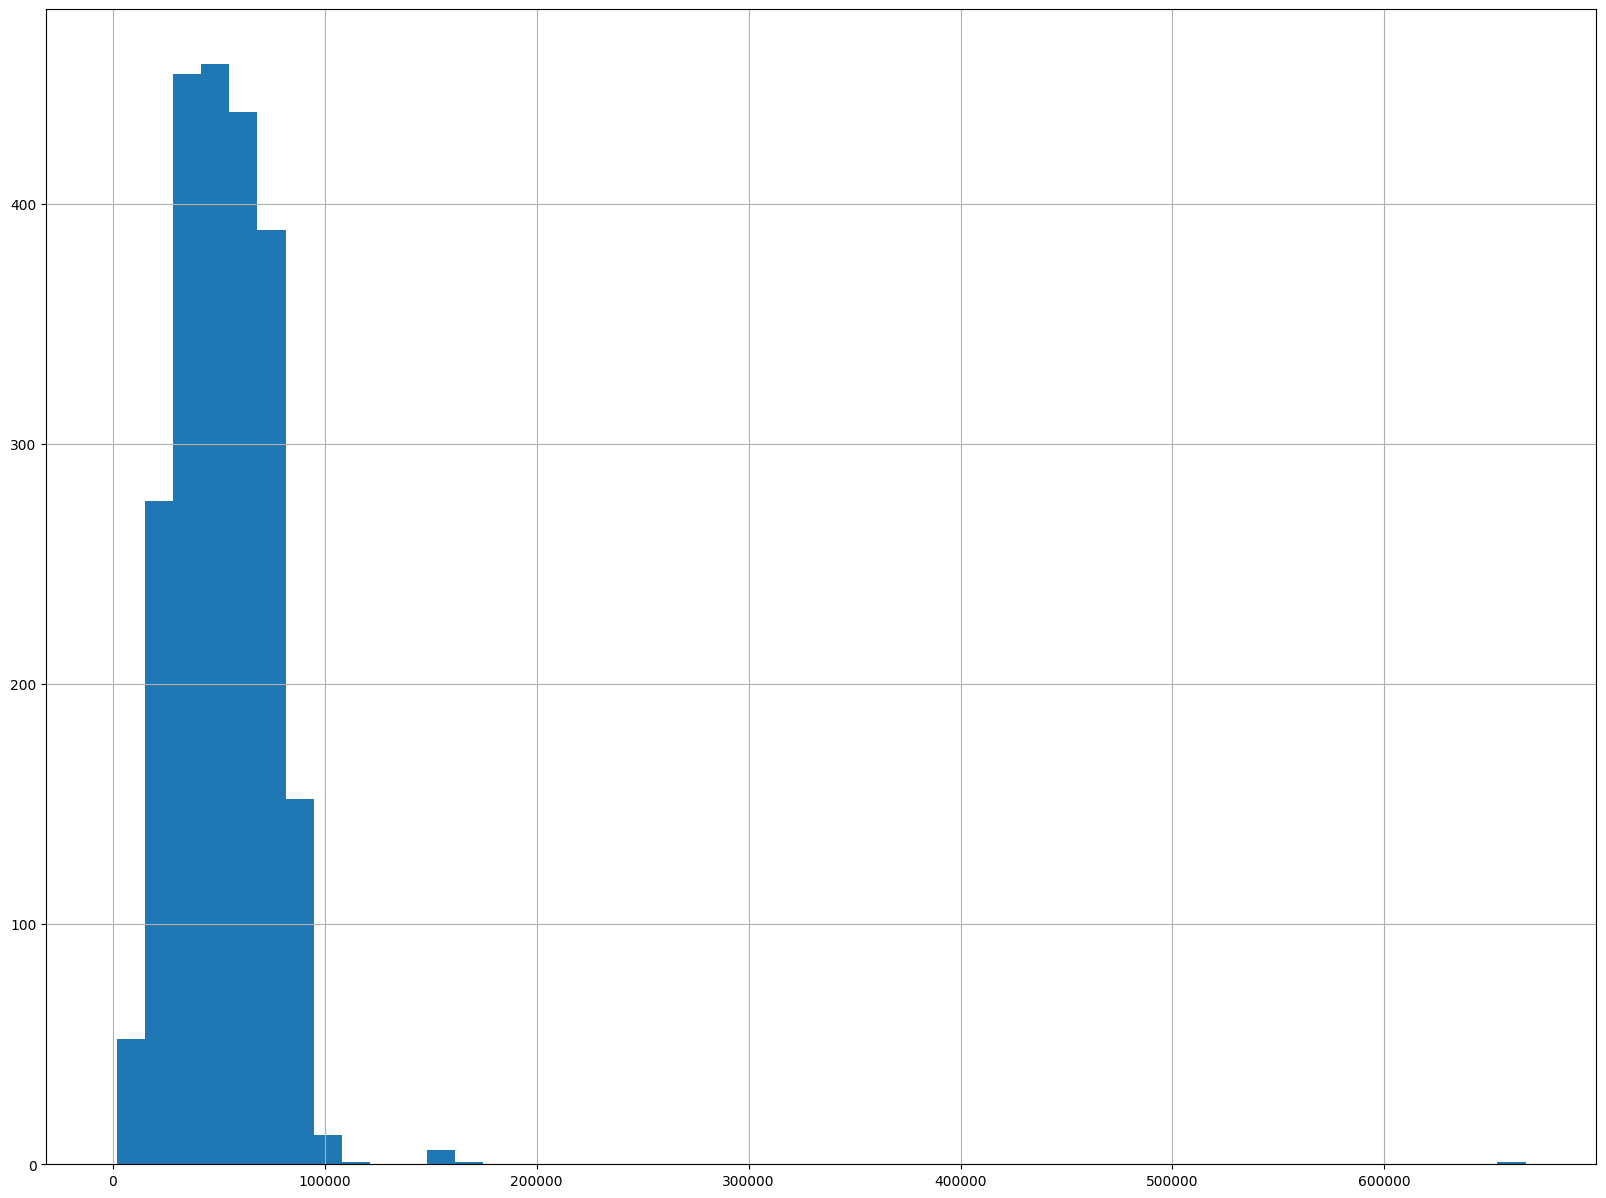

In [19]:
data2.hist(bins=50, figsize=(20,15))
plt.show()

In [20]:
print(data2.mean())
print(data2.median())

52237.97544642857
51381.5


In [21]:
df.dropna(subset=['Income'], inplace=True)
df.dropna(subset=['adults_in_home'], inplace=True)


In [22]:
print(df.isnull().sum())

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                  0
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
Education_2n Cycle      0
Education_Basic         0
Education_Graduation    0
Education_Master        0
Education_PhD           0
days_a_customer         0
Age                     0
adults_in_home          0
Spent                   0
Children    

# making new feature after removing missing in income

In [23]:
df["IncomePer"] =df["Income"]/df["Family_Size"]

# REMOVING OUTLIER

In [24]:
#Zohreh
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]

# LOOKING INTO DATA AFTER PREPSOCESSING

array([[<Axes: xlabel='Income', ylabel='Income'>,
        <Axes: xlabel='MntWines', ylabel='Income'>,
        <Axes: xlabel='MntFruits', ylabel='Income'>,
        <Axes: xlabel='MntMeatProducts', ylabel='Income'>,
        <Axes: xlabel='MntFishProducts', ylabel='Income'>,
        <Axes: xlabel='MntSweetProducts', ylabel='Income'>,
        <Axes: xlabel='MntGoldProds', ylabel='Income'>],
       [<Axes: xlabel='Income', ylabel='MntWines'>,
        <Axes: xlabel='MntWines', ylabel='MntWines'>,
        <Axes: xlabel='MntFruits', ylabel='MntWines'>,
        <Axes: xlabel='MntMeatProducts', ylabel='MntWines'>,
        <Axes: xlabel='MntFishProducts', ylabel='MntWines'>,
        <Axes: xlabel='MntSweetProducts', ylabel='MntWines'>,
        <Axes: xlabel='MntGoldProds', ylabel='MntWines'>],
       [<Axes: xlabel='Income', ylabel='MntFruits'>,
        <Axes: xlabel='MntWines', ylabel='MntFruits'>,
        <Axes: xlabel='MntFruits', ylabel='MntFruits'>,
        <Axes: xlabel='MntMeatProducts', y

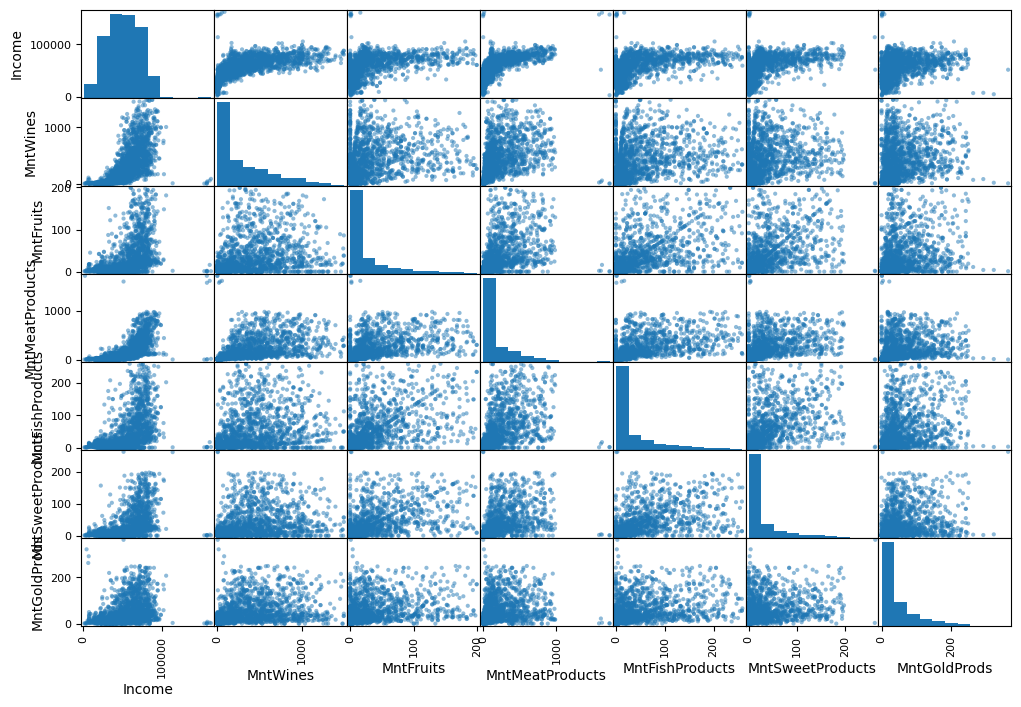

In [25]:
from pandas.plotting import scatter_matrix
attributes = ["Income", "MntWines", "MntFruits",
 "MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"]
scatter_matrix(df[attributes], figsize=(12, 8))

In [26]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
# Compute correlation matrix
corr_matrix = numeric_df.corr()
print(corr_matrix)

                           ID  Year_Birth    Income   Kidhome  Teenhome  \
ID                   1.000000    0.001862  0.000609  0.001816 -0.002995   
Year_Birth           0.001862    1.000000 -0.200011  0.234972 -0.363745   
Income               0.000609   -0.200011  1.000000 -0.510406  0.035285   
Kidhome              0.001816    0.234972 -0.510406  1.000000 -0.035405   
Teenhome            -0.002995   -0.363745  0.035285 -0.035405  1.000000   
Recency             -0.046415   -0.019242  0.007444  0.006898  0.018184   
MntWines            -0.020938   -0.163582  0.686223 -0.496348  0.005135   
MntFruits            0.006909   -0.014800  0.504288 -0.372467 -0.174764   
MntMeatProducts     -0.001942   -0.029779  0.684528 -0.437343 -0.260571   
MntFishProducts     -0.023448   -0.044015  0.518241 -0.387531 -0.202165   
MntSweetProducts    -0.006441   -0.020284  0.518206 -0.371230 -0.162173   
MntGoldProds        -0.011160   -0.060274  0.382598 -0.349007 -0.017952   
NumDealsPurchases   -0.03

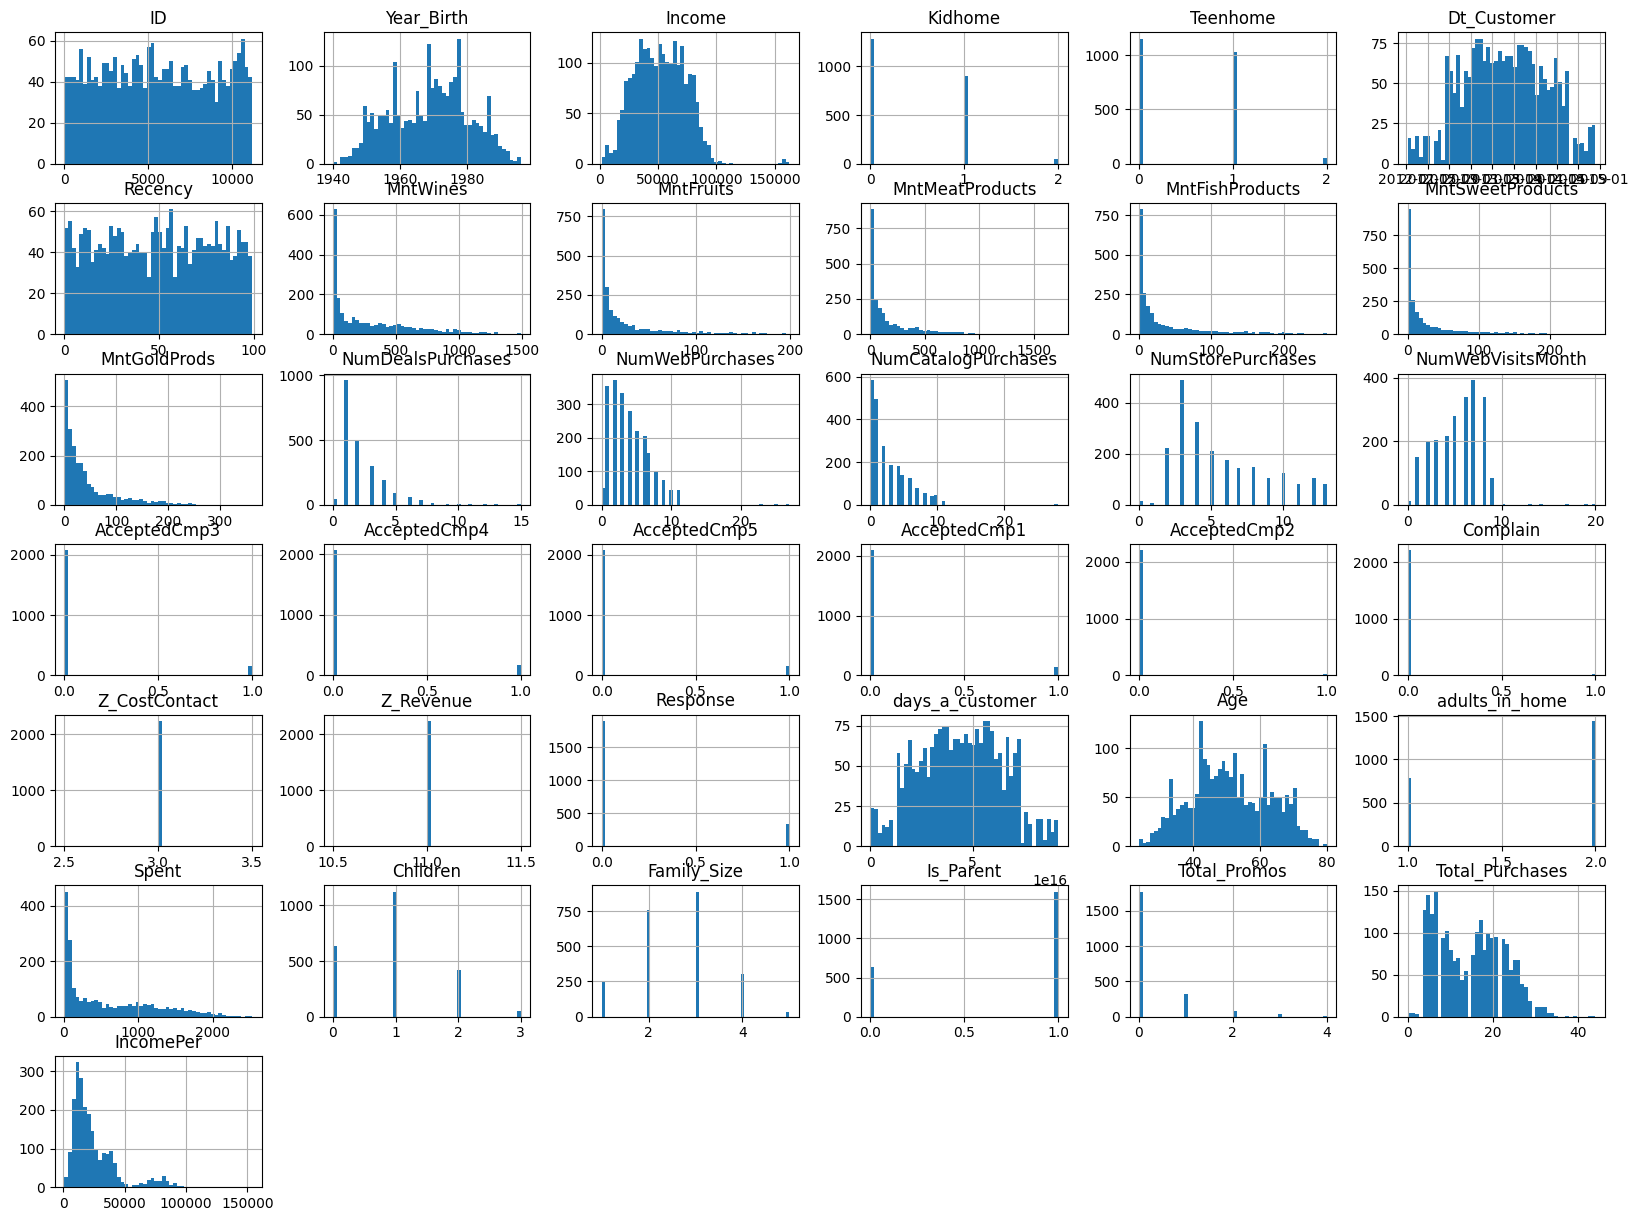

In [27]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [28]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'days_a_customer', 'Age',
       'adults_in_home', 'Spent', 'Children', 'Family_Size', 'Is_Parent',
       'Total_Promos', 'Total_Purchases', 'IncomePer'],
      dtype='object')

# Features Selection

In [29]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [30]:
# Features:
features = ['Income', 'Age', 'Total_Spent', 'Recency', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

In [31]:
# Feature Scaling and Encoding
## Define a transformer for scaling numerical features
numeric_features = ['Income', 'Age', 'Recency', 'adults_in_home', 'Spent', 'Children', 'Family_Size',
       'Total_Promos', 'Total_Purchases', 'IncomePer']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [32]:
## Define a transformer for encoding categorical features
categorical_features = ['Education', 'Marital_Status']
categorical_transformer = OneHotEncoder()

In [33]:
## Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [34]:
## Apply transformations
X_prepared = preprocessor.fit_transform(df)

# Clustering

In [35]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Assuming X_prepared is the pre-processed data ready for clustering

# Range of clusters to try
range_n_clusters = list(range(2, 11))

# Store average silhouette scores for each n_clusters
silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_prepared)
    
    # Silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(X_prepared, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

# Find the optimal number of clusters, based on silhouette score
optimal_n_clusters = range_n_clusters[silhouette_avg_scores.index(max(silhouette_avg_scores))]
print(f"The optimal number of clusters is : {optimal_n_clusters}")


For n_clusters = 2, the average silhouette_score is : 0.24172915284343327
For n_clusters = 3, the average silhouette_score is : 0.18130367019710197
For n_clusters = 4, the average silhouette_score is : 0.19592082349374057
For n_clusters = 5, the average silhouette_score is : 0.1767839816010556
For n_clusters = 6, the average silhouette_score is : 0.18034523354595475
For n_clusters = 7, the average silhouette_score is : 0.18556044440827774
For n_clusters = 8, the average silhouette_score is : 0.1883828286792699
For n_clusters = 9, the average silhouette_score is : 0.19115064847770988
For n_clusters = 10, the average silhouette_score is : 0.185631946237615
The optimal number of clusters is : 2


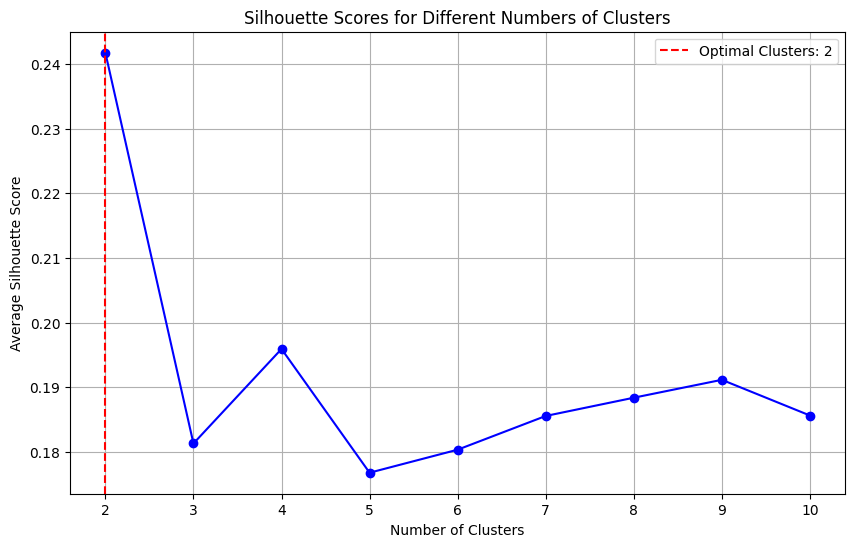

In [36]:
import matplotlib.pyplot as plt

# Assuming the silhouette_avg_scores and range_n_clusters from the previous code snippet

# Plotting the silhouette scores for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o', linestyle='-', color='blue')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.grid(True)

# Highlighting the optimal number of clusters
optimal_index = silhouette_avg_scores.index(max(silhouette_avg_scores))
optimal_n_clusters = range_n_clusters[optimal_index]
plt.axvline(x=optimal_n_clusters, linestyle='--', color='red', label=f'Optimal Clusters: {optimal_n_clusters}')
plt.legend()

plt.show()


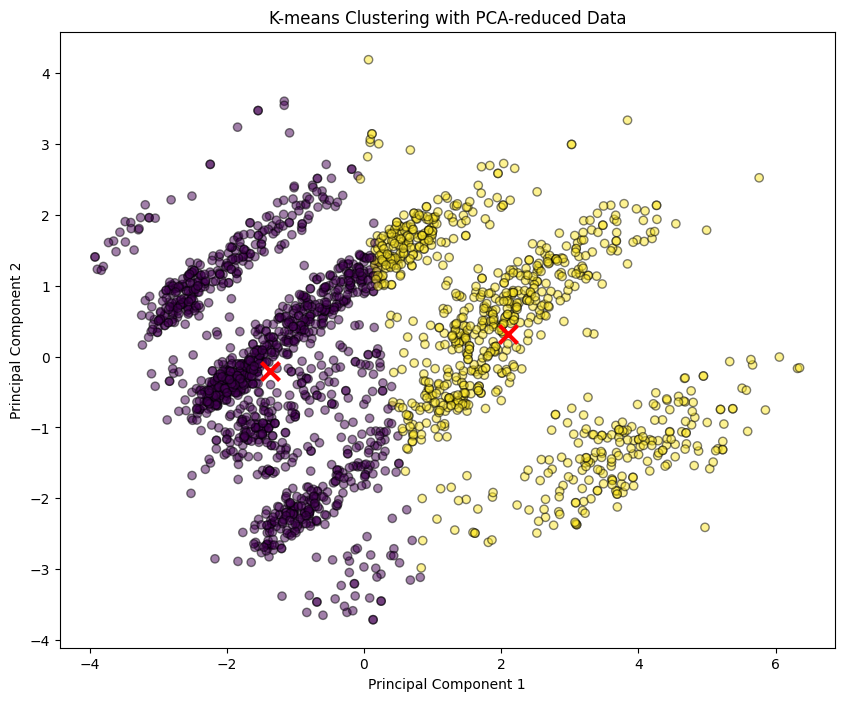

In [37]:
from sklearn.decomposition import PCA

# Clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_prepared)

# Applying PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_prepared)

# Plotting the clustered data
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5, edgecolor='k')

# Plotting the centroids
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)

plt.title('K-means Clustering with PCA-reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


# Customer profiling:

In [38]:
df['Cluster'] = clusters

In [39]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'data' is your DataFrame and it includes a 'Cluster' column
numerical_features = ['Income', 'Age', 'Recency', 'adults_in_home', 'Spent', 'Children', 'Family_Size',
       'Total_Promos', 'Total_Purchases', 'IncomePer']
categorical_features = ['Education', 'Marital_Status']

# Aggregate numerical features by cluster
cluster_profiles_num = df.groupby('Cluster')[numerical_features].mean()

# # Aggregate categorical features by cluster - using mode
# cluster_profiles_cat = df.groupby('Cluster')[categorical_features].agg(lambda x: stats.mode(x)[0])

# # Combine the numerical and categorical profiles
# cluster_profiles = pd.concat([cluster_profiles_num, cluster_profiles_cat], axis=1)

# print(cluster_profiles)


In [40]:
# Corrected approach for aggregating categorical features by cluster
def aggregate_categorical_mode(df, categorical_features, cluster_col='Cluster'):
    mode_data = {}
    for feature in categorical_features:
        mode_series = df.groupby(cluster_col)[feature].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
        mode_data[feature] = mode_series
    return pd.DataFrame(mode_data)

# Use the function to aggregate categorical features by mode
cluster_profiles_cat_corrected = aggregate_categorical_mode(df, categorical_features, 'Cluster')

# Combine the numerical and corrected categorical profiles
cluster_profiles_corrected = pd.concat([cluster_profiles_num, cluster_profiles_cat_corrected], axis=1)

cluster_profiles_cat_corrected


,Education,Marital_Status
Cluster,,
0,Graduation,Married
1,Graduation,Married


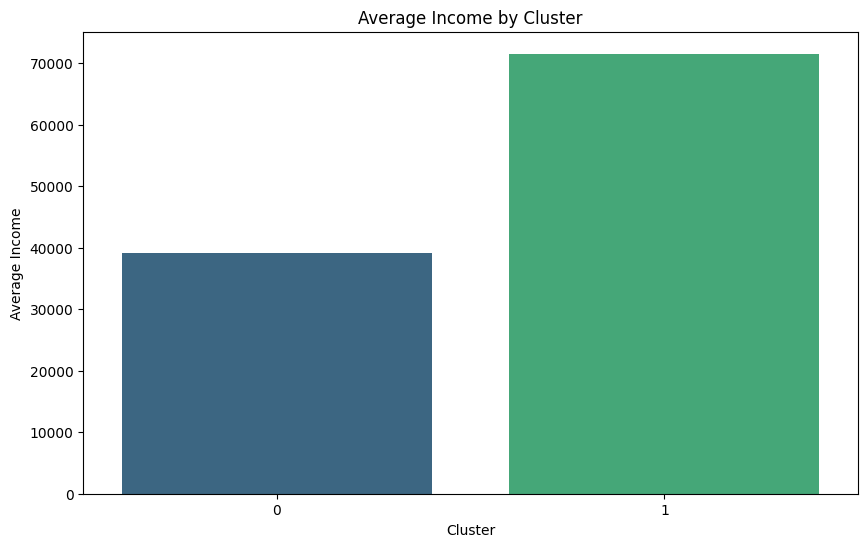

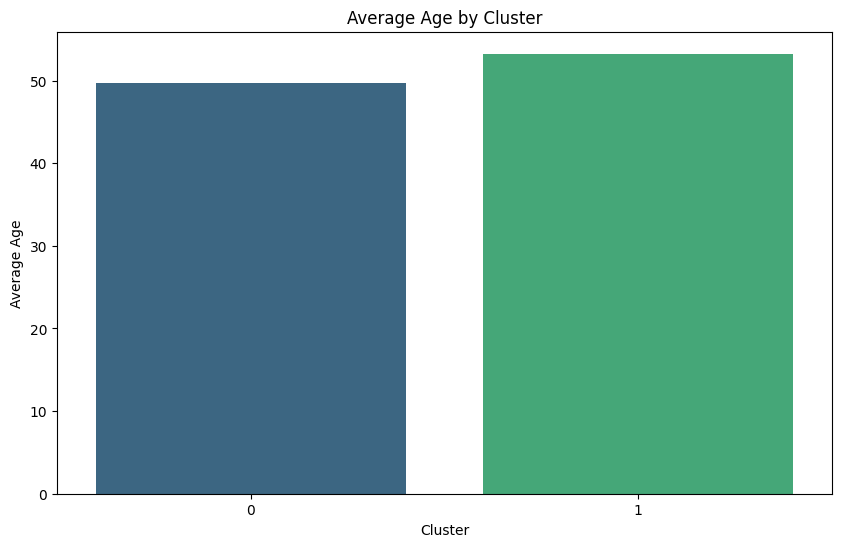

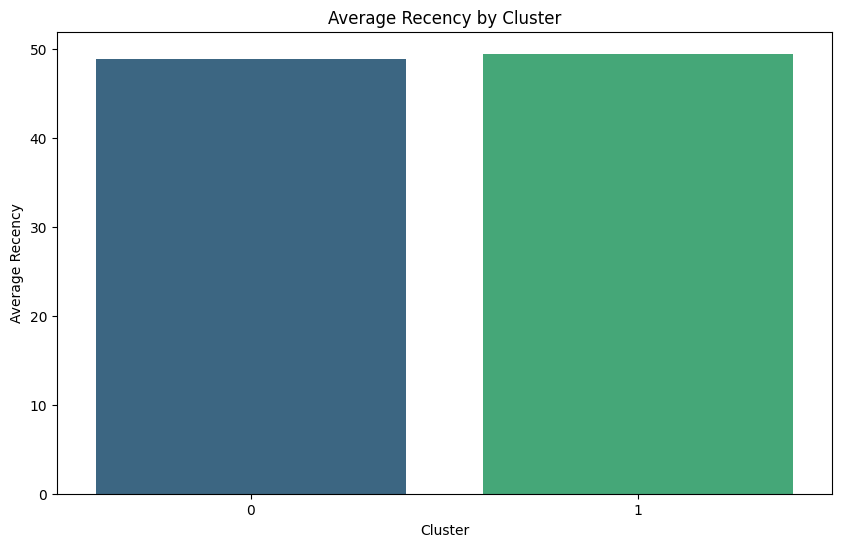

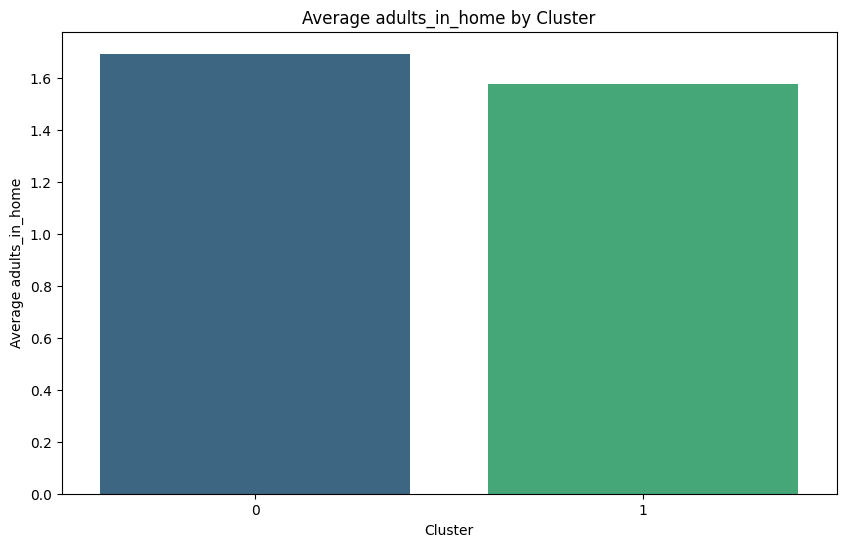

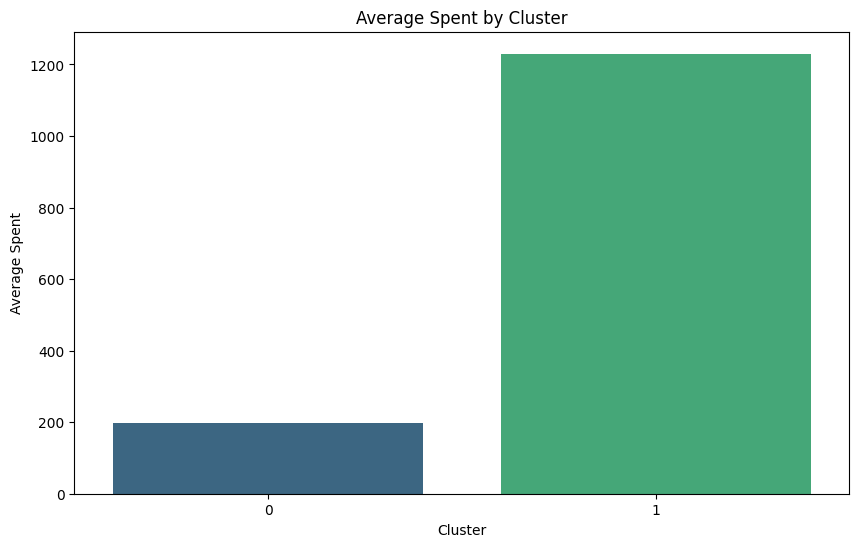

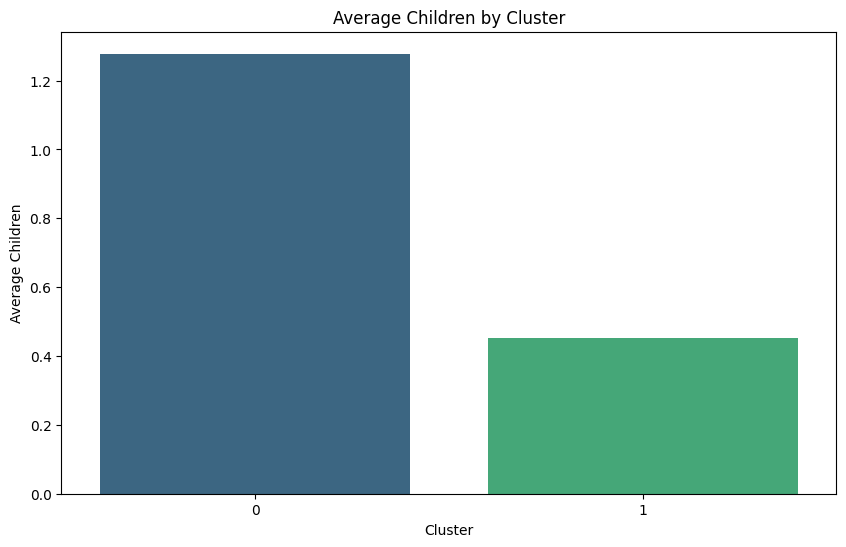

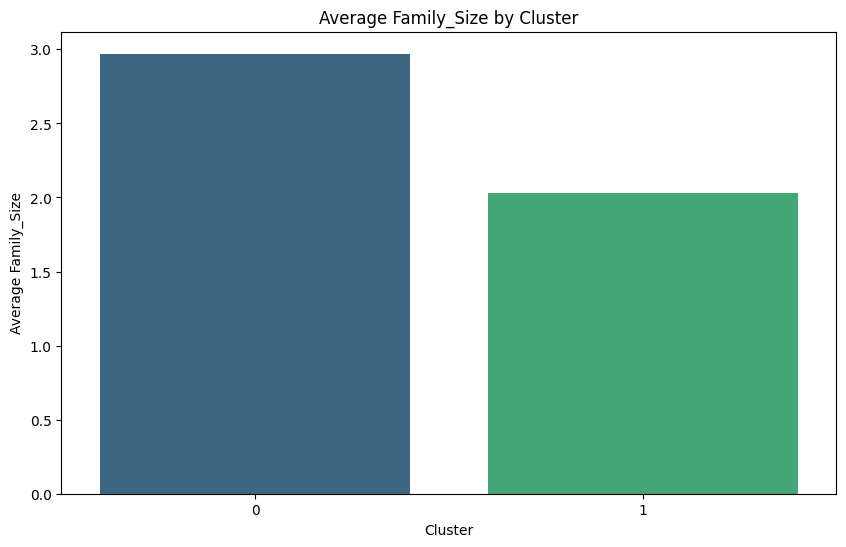

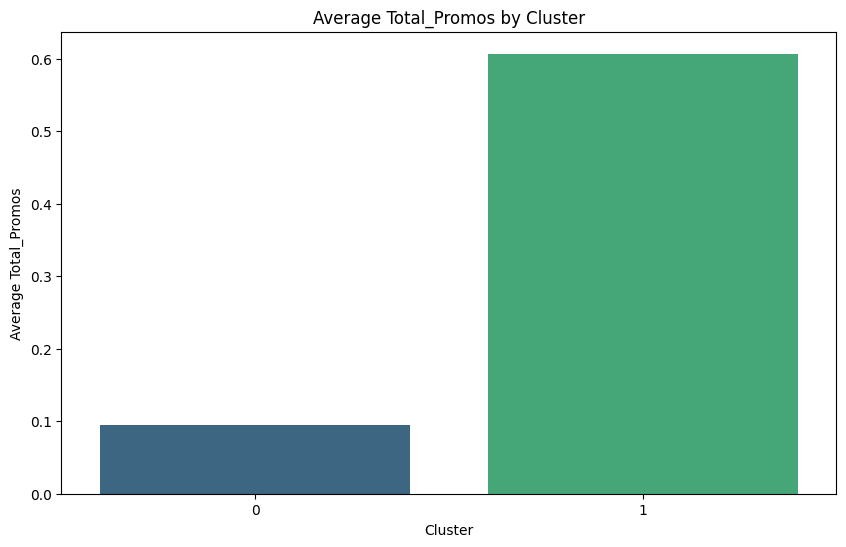

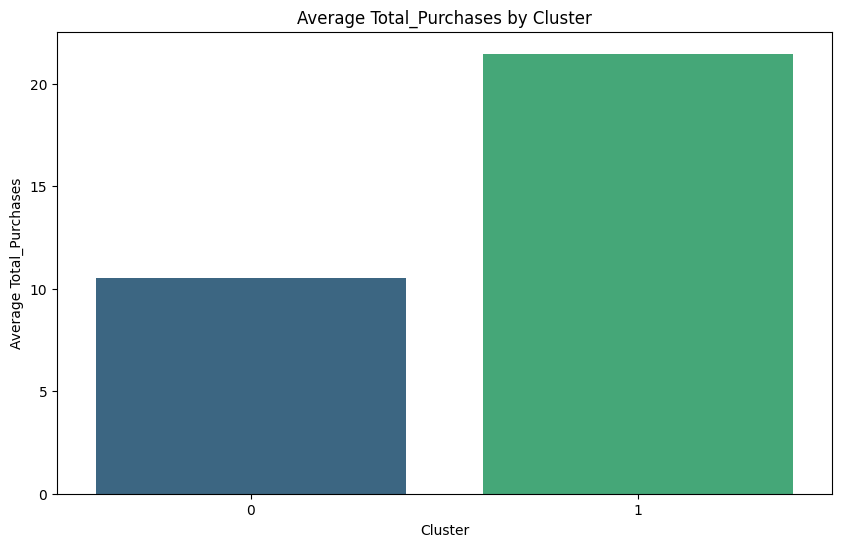

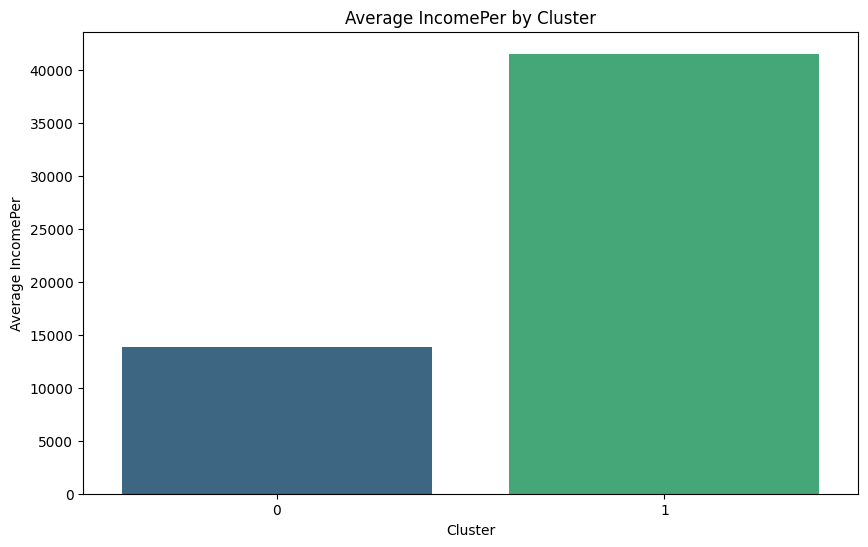

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the numerical features for each cluster
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cluster_profiles_corrected.index, y=cluster_profiles_corrected[feature], palette="viridis")
    plt.title(f'Average {feature} by Cluster')
    plt.ylabel(f'Average {feature}')
    plt.xlabel('Cluster')
    plt.show()



# Script for Training a Classifier

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [43]:
# Assuming 'clusters' are the cluster labels obtained from K-means
df['Cluster_Label'] = clusters

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Selecting the relevant features
features = ['Age', 'Education', 'Marital_Status', 'Income', 'Family_Size', 'Is_Parent',
            'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Total_Purchases',
            'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Total_Promos',
            'Recency', 'NumWebVisitsMonth', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'Cluster_Label']

X = df[features]
y = df['Response']  # Assuming cluster labels are stored here

# Preprocessing: Encoding categorical variables and scaling numerical variables
categorical_features = ['Education', 'Marital_Status']
numerical_features = [feature for feature in features if feature not in categorical_features]

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(), categorical_features)
])


In [45]:
X_processed = preprocessor.fit_transform(X)

In [46]:
# Prepare features (X) and target (y)
X = X_processed # Features already prepared for clustering can be used
y = df['Response']  # Target is the cluster labels

In [47]:
class_distribution = y.value_counts()
print(class_distribution)

Response
0    1900
1     332
Name: count, dtype: int64


# Balance the class Split the data into training and testing sets


In [48]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split original dataset into features (X) and target (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print(y_train_smote.value_counts())

# Now, X_train_smote and y_train_smote have balanced classes


Response
1    1524
0    1524
Name: count, dtype: int64


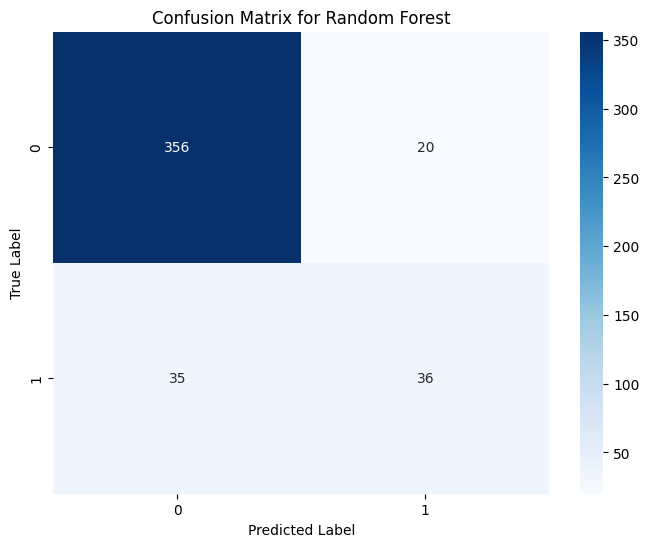

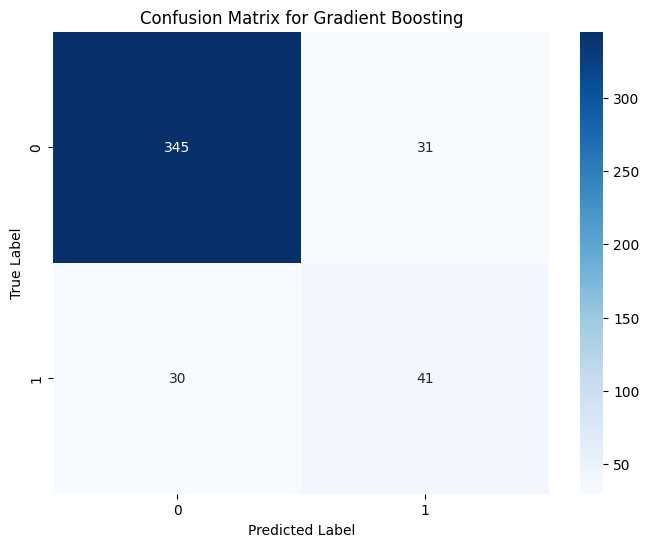

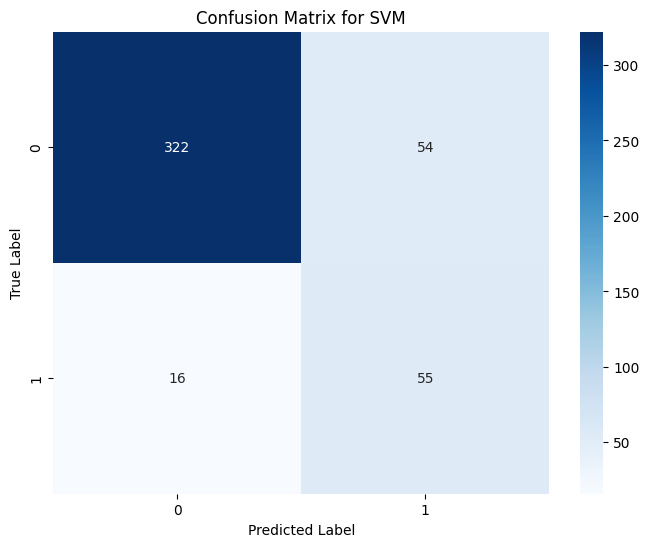

Random Forest Accuracy: 0.8770
Random Forest Classification Report: 
              precision    recall  f1-score   support

     Class 0       0.91      0.95      0.93       376
     Class 1       0.64      0.51      0.57        71

    accuracy                           0.88       447
   macro avg       0.78      0.73      0.75       447
weighted avg       0.87      0.88      0.87       447


Gradient Boosting Accuracy: 0.8635
Gradient Boosting Classification Report: 
              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92       376
     Class 1       0.57      0.58      0.57        71

    accuracy                           0.86       447
   macro avg       0.74      0.75      0.75       447
weighted avg       0.86      0.86      0.86       447


SVM Accuracy: 0.8434
SVM Classification Report: 
              precision    recall  f1-score   support

     Class 0       0.95      0.86      0.90       376
     Class 1       0.50      0.77      0

In [49]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(random_state=42)
}

# Dictionary to hold accuracy scores and classification reports
accuracy_scores = {}
classification_reports = {}

# Train each classifier and evaluate performance
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train_smote, y_train_smote)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy and save it
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = accuracy
    
    # Calculate precision, recall, and F1-score, and save the report
    report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=False)  # Adjust target_names as per your classes
    classification_reports[name] = report
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Display accuracy scores and classification reports for comparison
for model in classifiers.keys():
    print(f'{model} Accuracy: {accuracy_scores[model]:.4f}')
    print(f'{model} Classification Report: \n{classification_reports[model]}\n')
